#  CNN Classifier for  SER (Speech Emotion Recognition)

## Dataset

The Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS),and it is free to download. This dataset has 7356 files rated by 247 individuals 10 times on emotional validity, intensity, and genuineness. here the Speech files of all actors (01-24) will be used and the files are available under path ../datasets/RAVDESS. It contains 1440 files: 60 trials per actor x 24 actors = 1440. 
Filename identifiers:
<ol>
<li>Modality (01 = full-AV, 02 = video-only, 03 = audio-only).</li>
<li>Vocal channel (01 = speech, 02 = song).</li>
<li>Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).</li>
<li>Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.</li>
<li>Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").</li>
<li>Repetition (01 = 1st repetition, 02 = 2nd repetition)..</li>
<li>Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).</li>
</ol>

## Downloading Libraries

In [1]:
#!pip install librosa soundfile numpy sklearn pyaudio

In [2]:
#!pip install soundfile

In [3]:
pip install --upgrade pip

Note: you may need to restart the kernel to use updated packages.


In [4]:
#pip install tensorflow

In [5]:
#pip install keras==2.3.0

## Libraries Import

In [34]:
import os
import os.path
import soundfile
import librosa
import time
import numpy as np
import pandas as pd
import seaborn as sn

from librosa import display
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report,confusion_matrix
import joblib
import IPython.display as ipd  # To play sound in the notebook
import keras
import tensorflow as tf
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint

In [7]:
#import tensorflow as tf
#from tensorflow import keras
#from keras.preprocessing import sequence
#from keras.models import Sequential
#from keras.layers import Dense, Embedding
#from keras.utils import to_categorical
#from keras.layers import Input, Flatten, Dropout, Activation
#from keras.layers import Conv1D, MaxPooling1D
#from keras.models import Model
#from keras.callbacks import ModelCheckpoint

### Retrieve RAVDESS dataset from File System

In [8]:
RAV = "../datasets/RAVDESS/"
JOBLIB = "../datasets/JOBLIB/"
dir_list = os.listdir(RAV+"Actor_01/")
dir_list[0:5]

['03-01-01-01-01-01-01.wav',
 '03-01-01-01-01-02-01.wav',
 '03-01-01-01-02-01-01.wav',
 '03-01-01-01-02-02-01.wav',
 '03-01-02-01-01-01-01.wav']

In [9]:
#testing audio by select 1st actor(male) with sad motion
ipd.Audio(RAV + 'Actor_01/03-01-04-01-01-01-01.wav')

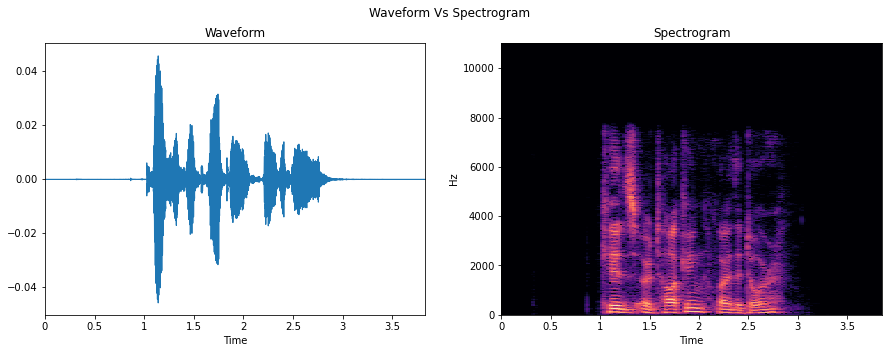

In [10]:
data, sr = librosa.load(RAV + 'Actor_01/03-01-04-01-01-01-01.wav')
ax = {}
fig, (ax) = plt.subplots(1, 2,figsize=(15,5))
fig.suptitle('Waveform Vs Spectrogram')
ax[0].set_title("Waveform")
librosa.display.waveplot(data, sr=sr,ax=ax[0])
ax[1].set_title("Spectrogram")
Xdb = librosa.amplitude_to_db(abs(librosa.stft(data)))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz',ax=ax[1])


In [11]:
dir_list = os.listdir(RAV)
dir_list.sort()
lst = []
start_time = time.time()
for i in dir_list:
    try:
        fname = os.listdir(RAV + i)
        #to get all actor's relative file path
        #print(fname)
        for f in fname:
            #print(RAV + i + '/' + f)
            data, sample_rate = librosa.load(RAV + i + '/' + f, res_type='kaiser_fast')
            mfccs = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=40).T,axis=0) 
            # The instruction below converts the labels (from 1 to 8) to a series from 0 to 7
            # This is because our predictor needs to start from 0 otherwise it will try to predict also 0.
            file = int(f[7:8]) - 1 
            arr = mfccs, file
            lst.append(arr)
    except ValueError:
        continue

print("Time Taken: %s sec" % (time.time() - start_time))

Time Taken: 37.51374316215515 sec


In [12]:
# Creating X and y: zip makes a list of all the first elements, and a list of all the second elements.
X, y = zip(*lst)
X = np.asarray(X)
y = np.asarray(y)
X.shape, y.shape

((1440, 40), (1440,))

In [13]:
# Saving joblib files to not load them again with the loop above
X_name = 'X.joblib'
y_name = 'y.joblib'
savedX = joblib.dump(X, os.path.join(JOBLIB, X_name))
savedy = joblib.dump(y, os.path.join(JOBLIB, y_name))

In [14]:
# Retrieve the data from the stored lib file
#X = joblib.load(JOBLIB+'X.joblib')
#y = joblib.load(JOBLIB+'y.joblib')

In [15]:
X.shape, y.shape

((1440, 40), (1440,))

## Decision Tree Classifier
By using a decision tree to accomplish this classification model:

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33, random_state=42)

In [17]:
dtree = DecisionTreeClassifier()

In [18]:
dtree.fit(X_train, y_train)

DecisionTreeClassifier()

In [19]:
predictions = dtree.predict(X_test)

In [20]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.27      0.29      0.28        28
           1       0.40      0.32      0.35        72
           2       0.22      0.22      0.22        58
           3       0.20      0.27      0.23        60
           4       0.54      0.55      0.55        60
           5       0.31      0.42      0.35        55
           6       0.37      0.30      0.33        74
           7       0.51      0.41      0.45        69

    accuracy                           0.35       476
   macro avg       0.35      0.35      0.35       476
weighted avg       0.36      0.35      0.35       476



## CNN (Convolutional Neural Networks) Classifier and Fit/Train the Model

In [21]:
x_traincnn = np.expand_dims(X_train, axis=2)
x_testcnn = np.expand_dims(X_test, axis=2)

In [22]:
x_traincnn.shape, x_testcnn.shape

((964, 40, 1), (476, 40, 1))

In [23]:
model = Sequential()

model.add(Conv1D(64, 5,padding='same',
                 input_shape=(40,1)))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(4)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(4)))
model.add(Conv1D(256, 5,padding='same',))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(8))
model.add(Activation('softmax'))
opt = keras.optimizers.RMSprop(lr=0.00005, rho=0.9, epsilon=1e-07, decay=0.0)

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 40, 64)            384       
_________________________________________________________________
activation (Activation)      (None, 40, 64)            0         
_________________________________________________________________
dropout (Dropout)            (None, 40, 64)            0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 10, 64)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 10, 128)           41088     
_________________________________________________________________
activation_1 (Activation)    (None, 10, 128)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 128)           0

In [25]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [26]:
cnnhistory=model.fit(x_traincnn, y_train, batch_size=16, epochs=200, validation_data=(x_testcnn, y_test))

Epoch 1/200
61/61 [==============================] - 2s 25ms/step - loss: 6.0914 - accuracy: 0.1395 - val_loss: 2.3903 - val_accuracy: 0.1218
Epoch 2/200
61/61 [==============================] - 0s 4ms/step - loss: 5.0788 - accuracy: 0.1518 - val_loss: 2.8411 - val_accuracy: 0.1261
Epoch 3/200
61/61 [==============================] - 0s 4ms/step - loss: 4.6618 - accuracy: 0.1324 - val_loss: 2.0402 - val_accuracy: 0.1681
Epoch 4/200
61/61 [==============================] - 0s 4ms/step - loss: 4.0579 - accuracy: 0.1446 - val_loss: 2.7029 - val_accuracy: 0.1786
Epoch 5/200
61/61 [==============================] - 0s 4ms/step - loss: 3.6677 - accuracy: 0.1602 - val_loss: 2.2156 - val_accuracy: 0.1387
Epoch 6/200
61/61 [==============================] - 0s 4ms/step - loss: 3.3863 - accuracy: 0.1336 - val_loss: 2.1570 - val_accuracy: 0.1618
Epoch 7/200
61/61 [==============================] - 0s 4ms/step - loss: 2.9397 - accuracy: 0.2024 - val_loss: 1.9427 - val_accuracy: 0.2500
Epoch 8/200


Epoch 59/200
61/61 [==============================] - 0s 4ms/step - loss: 1.7359 - accuracy: 0.3513 - val_loss: 1.7150 - val_accuracy: 0.3592
Epoch 60/200
61/61 [==============================] - 0s 4ms/step - loss: 1.7643 - accuracy: 0.3289 - val_loss: 1.6944 - val_accuracy: 0.3739
Epoch 61/200
61/61 [==============================] - 0s 4ms/step - loss: 1.7296 - accuracy: 0.3391 - val_loss: 1.7247 - val_accuracy: 0.3466
Epoch 62/200
61/61 [==============================] - 0s 4ms/step - loss: 1.7739 - accuracy: 0.3055 - val_loss: 1.7200 - val_accuracy: 0.3592
Epoch 63/200
61/61 [==============================] - 0s 4ms/step - loss: 1.7187 - accuracy: 0.3310 - val_loss: 1.7255 - val_accuracy: 0.3592
Epoch 64/200
61/61 [==============================] - 0s 4ms/step - loss: 1.7782 - accuracy: 0.3223 - val_loss: 1.7025 - val_accuracy: 0.3592
Epoch 65/200
61/61 [==============================] - 0s 4ms/step - loss: 1.6968 - accuracy: 0.3486 - val_loss: 1.6926 - val_accuracy: 0.3845
Epoch 

61/61 [==============================] - 0s 4ms/step - loss: 1.2732 - accuracy: 0.5077 - val_loss: 1.4946 - val_accuracy: 0.4475
Epoch 174/200
61/61 [==============================] - 0s 4ms/step - loss: 1.2850 - accuracy: 0.5453 - val_loss: 1.5035 - val_accuracy: 0.4307
Epoch 175/200
61/61 [==============================] - 0s 4ms/step - loss: 1.2739 - accuracy: 0.5202 - val_loss: 1.4852 - val_accuracy: 0.4769
Epoch 176/200
61/61 [==============================] - 0s 4ms/step - loss: 1.3061 - accuracy: 0.5015 - val_loss: 1.4668 - val_accuracy: 0.4517
Epoch 177/200
61/61 [==============================] - 0s 5ms/step - loss: 1.2997 - accuracy: 0.4998 - val_loss: 1.4754 - val_accuracy: 0.4832
Epoch 178/200
61/61 [==============================] - 0s 4ms/step - loss: 1.2704 - accuracy: 0.5142 - val_loss: 1.5255 - val_accuracy: 0.4349
Epoch 179/200
61/61 [==============================] - 0s 4ms/step - loss: 1.2366 - accuracy: 0.5364 - val_loss: 1.5058 - val_accuracy: 0.4349
Epoch 180/200

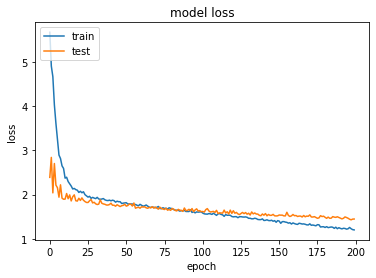

In [27]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

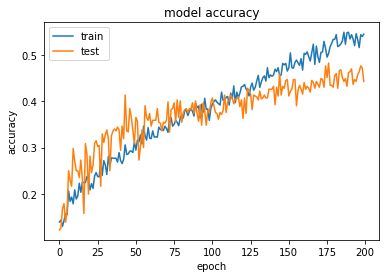

In [28]:
plt.plot(cnnhistory.history['accuracy'])
plt.plot(cnnhistory.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [29]:
predictions = model.predict_classes(x_testcnn)

C:\Users\User\anaconda3\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [30]:
new_Ytest = y_test.astype(int)

15/15 [==============================] - 0s 1ms/step - loss: 1.4498 - accuracy: 0.4433
Accuracy: 44.33%
Statistics:
              precision    recall  f1-score   support

           0       0.17      0.07      0.10        28
           1       0.53      0.65      0.58        72
           2       0.28      0.36      0.32        58
           3       0.34      0.40      0.37        60
           4       0.52      0.55      0.54        60
           5       0.55      0.51      0.53        55
           6       0.46      0.35      0.40        74
           7       0.51      0.43      0.47        69

    accuracy                           0.44       476
   macro avg       0.42      0.42      0.41       476
weighted avg       0.44      0.44      0.44       476

Confusion Matrix:


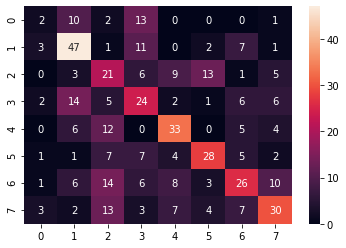

In [35]:
loss, accuracy = model.evaluate(x_testcnn, y_test)
print("Accuracy: {:.2f}%".format(accuracy*100))

print("Statistics:")
print(classification_report(new_Ytest, predictions))

print("Confusion Matrix:")
cm = confusion_matrix(new_Ytest, predictions)
df_cm = pd.DataFrame(cm)
sn.heatmap(df_cm, annot=True, fmt='')
plt.show()

By making use of the soundfile library to read the sound files, extracting features from each file and applying CNN Classifier, the model delivered an accuracy of 44.33.

In [36]:
model.save('testing10_model.h5')
print("MODEL SAVED")

MODEL SAVED


In [37]:
new_model=keras.models.load_model('testing10_model.h5')
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 40, 64)            384       
_________________________________________________________________
activation (Activation)      (None, 40, 64)            0         
_________________________________________________________________
dropout (Dropout)            (None, 40, 64)            0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 10, 64)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 10, 128)           41088     
_________________________________________________________________
activation_1 (Activation)    (None, 10, 128)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 128)           0